In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import Xception  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import multiprocessing

In [2]:
# Define the path to the data directory
data_dir = "C:/Users/HP/Desktop/terminal-data"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir, test_dir):
    train_counts = []
    val_counts = []
    test_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    for folder in os.listdir(test_dir):
        test_counts.append(len(os.listdir(os.path.join(test_dir, folder))))

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_counts, width, label='Train')
    rects2 = ax.bar(x, val_counts, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts, width, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


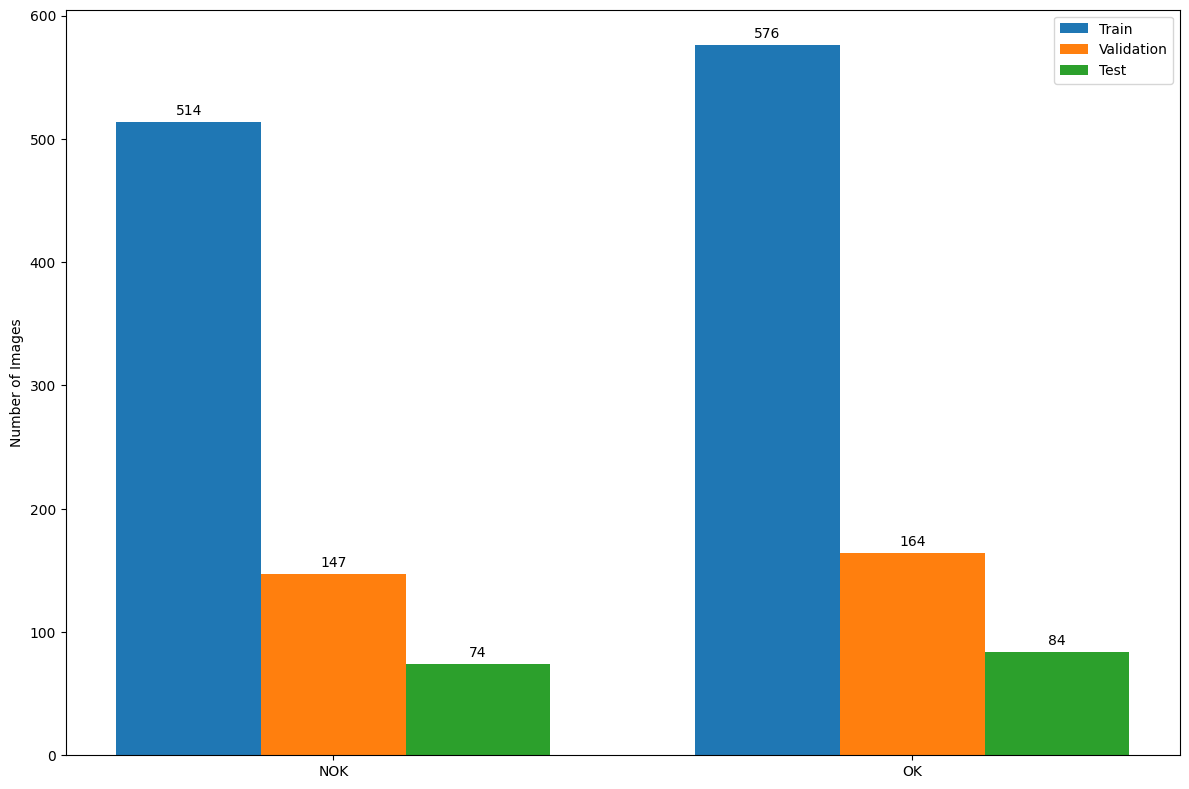

In [4]:
visualize_data(train_dir, val_dir, test_dir)

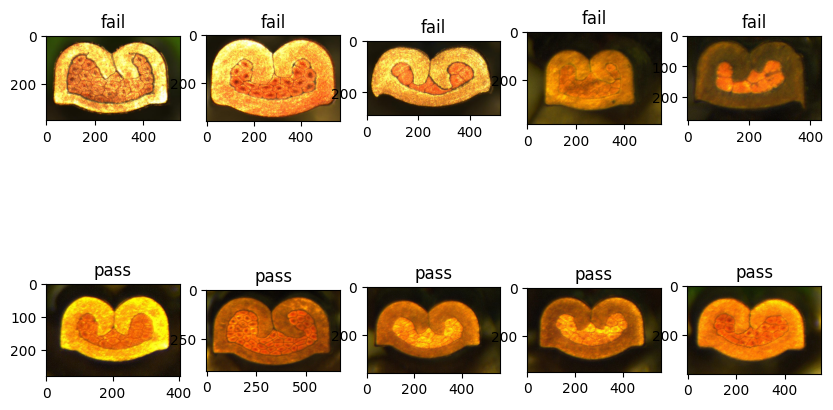

In [6]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("fail")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("pass")

plt.show()

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["OK", "NOK"],
    seed=42,
    shuffle=True
    )

Found 1090 images belonging to 2 classes.


In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["OK", "NOK"],
    seed=42,
    shuffle=True
    )

Found 311 images belonging to 2 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["OK", "NOK"],
    shuffle = False,
    seed=42
    )

Found 158 images belonging to 2 classes.


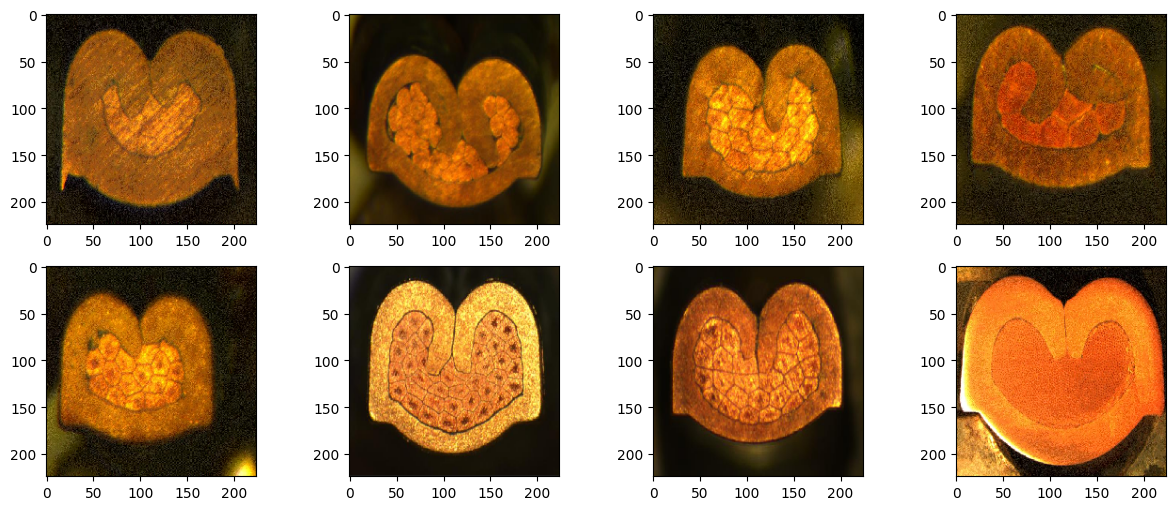

In [11]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [12]:
class_names = train_data.class_indices
class_names

{'OK': 0, 'NOK': 1}

In [13]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [14]:
class_weight_dict

{0: 0.9461805555555556, 1: 1.0603112840466926}

In [15]:
base_model = Xception(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

83683744/83683744 [==============================] - 9s 0us/step


In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002294B85BDF0>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x000002295017A740>,block1_conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022950161900>,block1_conv1_bn,False
3,<keras.layers.core.activation.Activation object at 0x0000022950161360>,block1_conv1_act,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000229501A6920>,block1_conv2,False
...,...,...,...
129,<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x000002298A1386D0>,block14_sepconv2,False
130,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002298A13B4F0>,block14_sepconv2_bn,False
131,<keras.layers.core.activation.Activation object at 0x0000022957F1D5A0>,block14_sepconv2_act,False
132,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002294E4C19F0>,global_average_pooling2d,True


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [19]:
recall = Recall()
precision = Precision()

In [20]:
#optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [21]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [22]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb]
                  )

Epoch 1/10
136/136 [==============================] - 28s 162ms/step - loss: 0.6186 - accuracy: 0.7043 - recall: 0.6797 - precision: 0.6905 - val_loss: 0.7089 - val_accuracy: 0.6908 - val_recall: 0.9375 - val_precision: 0.6136
Epoch 2/10
136/136 [==============================] - 19s 141ms/step - loss: 0.3682 - accuracy: 0.8253 - recall: 0.8055 - precision: 0.8200 - val_loss: 0.4276 - val_accuracy: 0.7632 - val_recall: 0.6301 - val_precision: 0.8364
Epoch 3/10
136/136 [==============================] - 19s 138ms/step - loss: 0.2889 - accuracy: 0.8678 - recall: 0.8477 - precision: 0.8697 - val_loss: 0.3608 - val_accuracy: 0.8322 - val_recall: 0.7778 - val_precision: 0.8550
Epoch 4/10
136/136 [==============================] - 19s 137ms/step - loss: 0.2063 - accuracy: 0.9159 - recall: 0.9045 - precision: 0.9170 - val_loss: 0.5051 - val_accuracy: 0.7862 - val_recall: 0.9510 - val_precision: 0.7010
Epoch 5/10
136/136 [==============================] - 19s 138ms/step - loss: 0.2244 - accura

In [23]:
len(base_model.layers)

132

In [24]:
base_model.trainable = True
# Freeze the first 100 layers 
for layer in base_model.layers:
  layer.trainable = False

In [25]:
for layer in base_model.layers:
  layer.trainable = True

In [26]:
#optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [27]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002294B85BDF0>,input_1,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x000002295017A740>,block1_conv1,True
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022950161900>,block1_conv1_bn,True
3,<keras.layers.core.activation.Activation object at 0x0000022950161360>,block1_conv1_act,True
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000229501A6920>,block1_conv2,True
...,...,...,...
129,<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x000002298A1386D0>,block14_sepconv2,True
130,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002298A13B4F0>,block14_sepconv2_bn,True
131,<keras.layers.core.activation.Activation object at 0x0000022957F1D5A0>,block14_sepconv2_act,True
132,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002294E4C19F0>,global_average_pooling2d,True


In [28]:
df['Layer Trainable'].value_counts()[True]

134

In [29]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [30]:
#reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [31]:
checkpoint_cb = ModelCheckpoint('model.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [32]:
csv_logger = CSVLogger('training_log.csv')

In [33]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, csv_logger]
                   )

Epoch 1/100
136/136 [==============================] - 64s 434ms/step - loss: 0.9336 - accuracy: 0.5065 - recall: 0.5367 - precision: 0.5783 - val_loss: 36.0712 - val_accuracy: 0.5592 - val_recall: 0.0769 - val_precision: 0.8462
Epoch 2/100
136/136 [==============================] - 45s 332ms/step - loss: 0.7129 - accuracy: 0.5028 - recall: 0.2779 - precision: 0.4566 - val_loss: 2.0903 - val_accuracy: 0.4803 - val_recall: 1.0000 - val_precision: 0.4803
Epoch 3/100
136/136 [==============================] - 51s 376ms/step - loss: 0.6928 - accuracy: 0.5786 - recall: 0.9121 - precision: 0.5319 - val_loss: 8.5501 - val_accuracy: 0.4770 - val_recall: 0.9586 - val_precision: 0.4760
Epoch 4/100
136/136 [==============================] - 24s 172ms/step - loss: 0.6713 - accuracy: 0.5749 - recall: 0.9094 - precision: 0.5274 - val_loss: 0.9079 - val_accuracy: 0.6776 - val_recall: 0.6761 - val_precision: 0.6486
Epoch 5/100
136/136 [==============================] - 17s 124ms/step - loss: 0.6582 - 

In [34]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

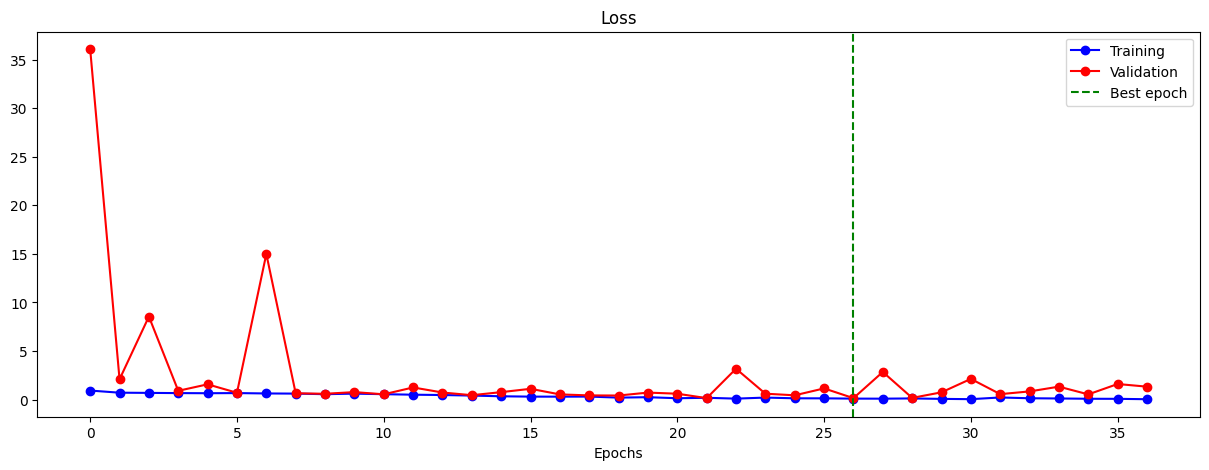

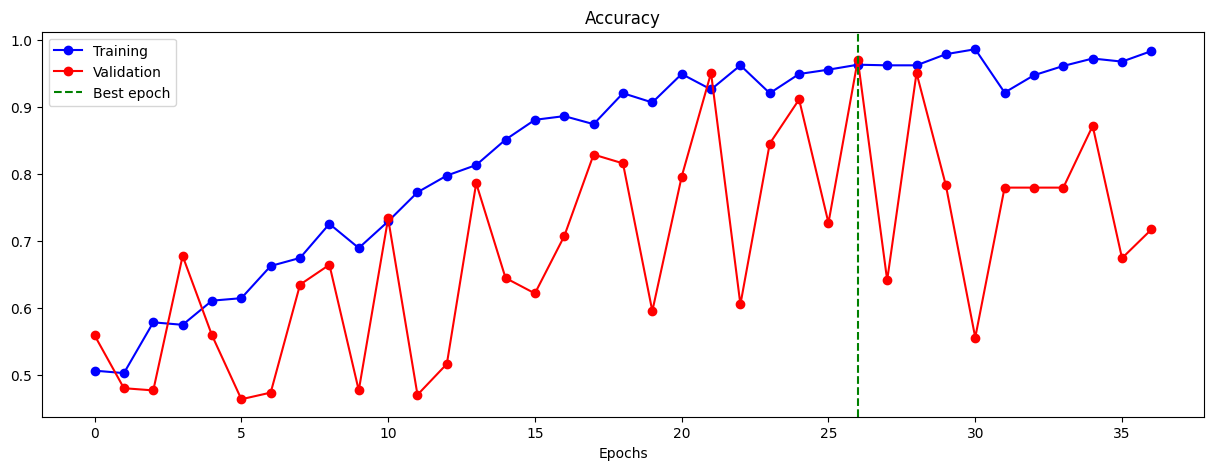

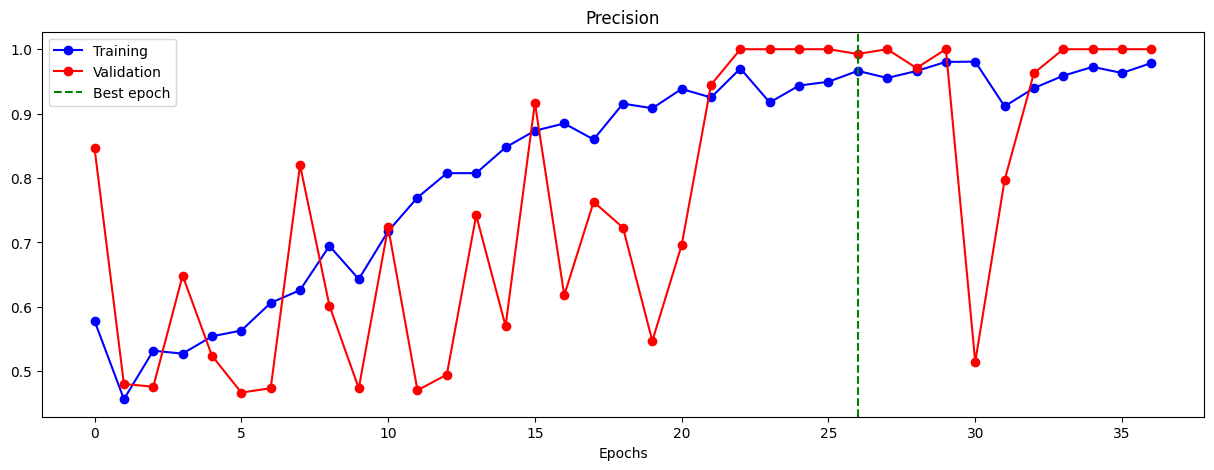

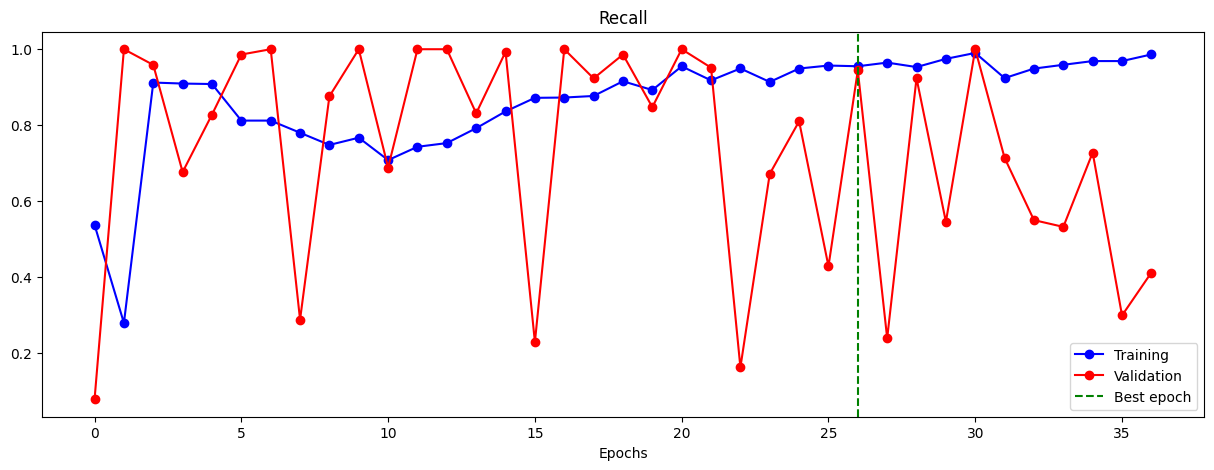

In [35]:
visualize_training_results(history)

In [36]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
 
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


20/20 [==============================] - 4s 199ms/step


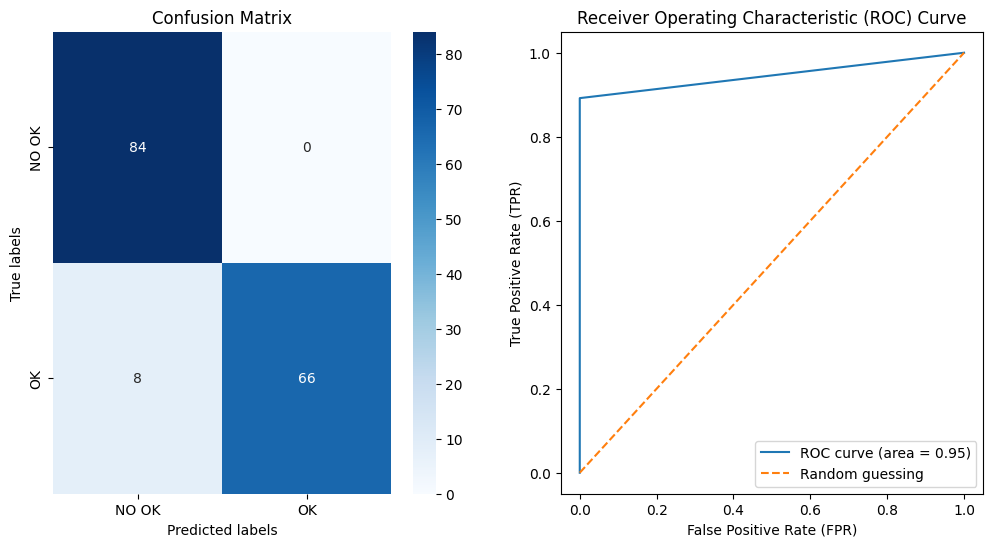

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        84
           1       1.00      0.89      0.94        74

    accuracy                           0.95       158
   macro avg       0.96      0.95      0.95       158
weighted avg       0.95      0.95      0.95       158



In [37]:
plot_metrics(model, test_data)

In [38]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  26
Best loss:  0.10351035743951797
Best accuracy:  0.9630314111709595
Best recall:  0.955078125
Best precision:  0.9664031863212585
Best val_loss:  0.15168800950050354
Best val_accuracy:  0.9703947305679321
Best val_recall:  0.9440559148788452
Best val_precision:  0.9926470518112183
